In [ ]:
1. 동전이미지를 이용한 윤곽선(물체구분). opencv(이미지 검출, 히스토그램, 레이블 지정 등)

2. 이미지 영상 + CNN 기법 접목
  - 데이터를 학습데이터 로드
  - 데이터를 늘리는 방법
  - 데이터를 생성하는 방법
    
3. 학습, 예측률

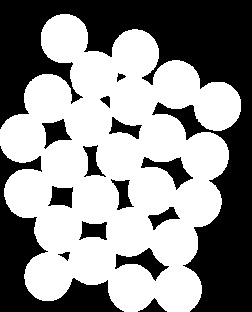

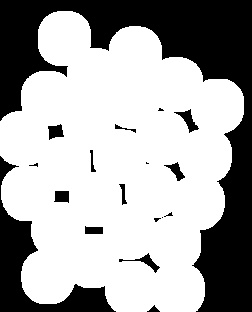

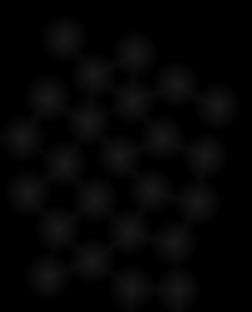

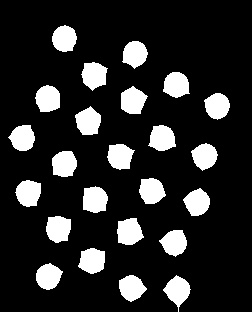

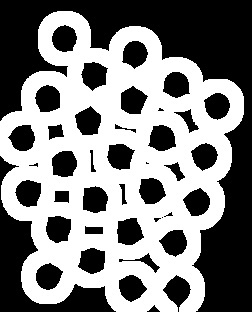

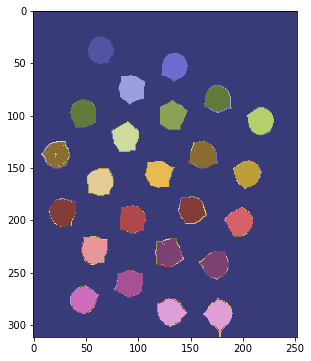

In [120]:
# 1.동전 이미지 윤곽 분리하는 방법 : cv2.watershed() = 라벨을 바탕으로 윤곽을 추출한다.
# 2. 2진화 작업 -> 흑백 -> 노이즈 제거 -> sure Background 추출(cv2.dilate())
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt

def imshow(img):
    ret, encoded = cv2.imencode('.jpg', img)
    display(Image(encoded))
    
img = cv2.imread('C:\\Users\\user\\MyPython\\img\\coin02.jpg')
# img = cv2.imread('C:\\Users\\user\\MyPython\\img\\people2.jpg')
# img = cv2.imread('C:\\Users\\user\\MyPython\\img\\money.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   # BGR -> 흑백

# 2진화 작업
ret, bin_img = cv2.threshold(gray, 0 ,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 노이즈 제거, 질감, 모양, 활성화
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)
imshow(bin_img)

# sure Background 추출 : 대상을 그룹으로 만들고 -> 배경과 그룹을 분리한다.
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg)

# 거리를 구한다.
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist)

# sure Background 추출
ret, sure_fg = cv2.threshold(dist, 0.5*dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg)

# 배경인지 전경인지 구분할 수 있는 영역이 된다.
unknow = cv2.subtract(sure_bg, sure_fg)
imshow(unknow)

# 레이블 0 : 전경 또는 배경인지 모르는 영역
# 레이블 1 : 배경
# 레이블 2~ : 대상(물체 : forground 2~25)
# 레이블 설정 cv2.connectedComponents()
ret, markers = cv2.connectedComponents(sure_fg)

markers += 1
markers[unknow==255] = 0

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(markers, cmap='tab20b')
plt.show()

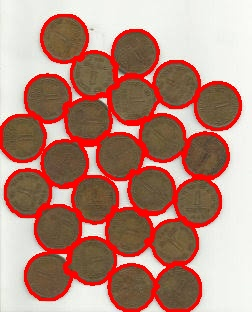

In [121]:
# watershed 알고리즘을 이용해서 윤곽선 추출
labels = np.unique(markers)
coins = []
markers = cv2.watershed(img, markers)  # 윤곽선 지정

# 0:미지의 영역, 1:배경영역
for label in labels[2:]:
    target = np.where(markers==label, 255, 0).astype(np.uint8)
    
    # 윤곽추출
    cnt, hierarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coins.append(cnt[0])
    
cv2.drawContours(img, coins, -1, color=(0,0,255), thickness=2)
imshow(img)

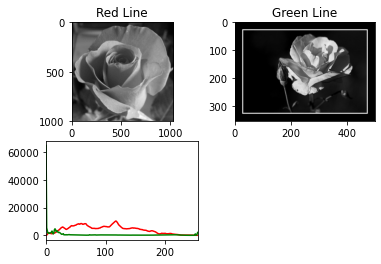

In [123]:
# 1-2. 히스토그램
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt

img1 = cv2.imread('C:\\Users\\user\\MyPython\\img\\flower1.jpg', 0)
img2 = cv2.imread('C:\\Users\\user\\MyPython\\img\\flower2.jpg', 0)

hist1 = cv2.calcHist([img1], [0], None, [256], [0,256])
hist2 = cv2.calcHist([img2], [0], None, [256], [0,256])

plt.subplot(221), plt.imshow(img1, 'gray'), plt.title('Red Line')
plt.subplot(222), plt.imshow(img2, 'gray'), plt.title('Green Line')
plt.subplot(223), plt.plot(hist1, color='r'), plt.plot(hist2, color='g')
plt.xlim([0,256])
plt.show()

In [129]:
# 2. 데이터 이미지 늘리는 방법
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator

DATA_DIR = 'C:\\Users\\user\\MyPython\\img'
IMAGE_NAME = 'apple.jpg'
SAVE_DIR = os.path.join(DATA_DIR, 'preview')   # 데이터를 부풀려서 저장할 디렉토리

datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2,  shear_range=0.2, zoom_range=0.2, fill_mode='nearest',
    horizontal_flip=True)

im_array = cv2.imread(os.path.join(DATA_DIR, IMAGE_NAME))  # 이미지 로드

# 차원 변환
im_array = im_array.reshape((1,) + im_array.shape)   # 4차원으로 변환

# 대상 디렉토리가 없으면 새로 만들자
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

i = 0
# 이미지 배치를 하자
for batch in datagen.flow(im_array, batch_size=1, save_to_dir=SAVE_DIR, save_prefix='apple', save_format='jpg'):
    i += 1
    if i == 10:
        break

datagen.flow(im_array, batch_size=1, save_to_dir=SAVE_DIR, save_prefix='apple', save_format='jpg')

In [129]:
# 2. 데이터 이미지 늘리는 방법
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator

DATA_DIR = 'C:\\Users\\user\\MyPython\\img'
IMAGE_NAME = 'apple.jpg'
SAVE_DIR = os.path.join(DATA_DIR, 'preview')   # 데이터를 부풀려서 저장할 디렉토리

datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2,  shear_range=0.2, zoom_range=0.2, fill_mode='nearest',
    horizontal_flip=True)

im_array = cv2.imread(os.path.join(DATA_DIR, IMAGE_NAME))  # 이미지 로드

# 차원 변환
im_array = im_array.reshape((1,) + im_array.shape)   # 4차원으로 변환

# 대상 디렉토리가 없으면 새로 만들자
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

i = 0
# 이미지 배치를 하자
for batch in datagen.flow(im_array, batch_size=1, save_to_dir=SAVE_DIR, save_prefix='apple', save_format='jpg'):
    i += 1
    if i == 10:
        break

datagen.flow(im_array, batch_size=1, save_to_dir=SAVE_DIR, save_prefix='apple', save_format='jpg')

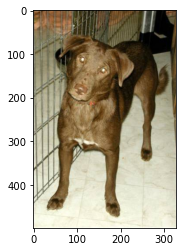

In [131]:
# 2. 이미지 영상 + CNN 기법 접목
# - 데이터를 학습데이터 로드 : 폴더명으로 카테고리를 분류하고 이미지를 로드하면 된다.
# - 데이터를 생성하는 방법
import cv2
import numpy as np
from matplotlib import pyplot as plt

DATA_DIR = 'C:\\Users\\user\\MyPython\\DL\\archive\\training_set\\training_set'
CATEGORIES = ['dogs', 'cats']

for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    for image_name in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, image_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

학습 데이터 레이블 : 0
학습 데이터 레이블 : 0
학습 데이터 레이블 : 1
학습 데이터 레이블 : 0


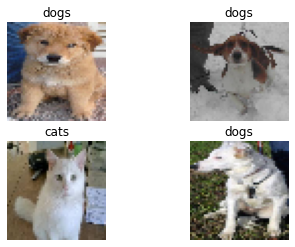

In [138]:
# 2. 이미지 영상 + CNN 기법 접목
# - 데이터를 학습데이터 로드 
#     1. 폴더명으로 카테고리를 분류하고 이미지를 로드하면 된다.
#     2. 이미지 크기 조정 후 레이블 추가 후 numpy 변환
# - 데이터를 생성하는 방법
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt

DATA_DIR = 'C:\\Users\\user\\MyPython\\DL\\archive\\training_set\\training_set'
CATEGORIES = ['dogs', 'cats']
training_data = []
IMG_SIZE = 50

def create_training_data():
    for class_num, category in enumerate(CATEGORIES):
        path = os.path.join(DATA_DIR, category)
        for image_name in os.listdir(path):
            try:   # 이미지 로드, 크기조정, 데이터 레이블 정보 추가
                img_array = cv2.imread(os.path.join(path, image_name))
#                 img_array = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)   # 흑백
                img_resize_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))   # 이미지 크기 조정
                training_data.append([img_resize_array, class_num])
                
            except Exception as e:
                pass
            
create_training_data()
random.shuffle(training_data)

X_train = []   # 이미지 데이터
y_train = []   # 레이블 정보

# 데이터 셋 설정
for feature, label in training_data:
    X_train.append(feature)
    y_train.append(label)
    
# numpy 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

# 데이터 셋 확인
for i in range(0,4):
    print('학습 데이터 레이블 :', y_train[i])
    plt.subplot(2,2, i+1)
    plt.axis('off')
    plt.title(label = 'dogs' if y_train[i]==0 else 'cats')
#     plt.imshow(X_train[i], cmap='gray')   # 흑백
    
    img_array = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_array)

In [143]:
# 모델 생성
from keras import layers
from keras import models
from keras import optimizers

# 순차 모델 생성
model = models.Sequential()

# Conv2D -> 4
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
          
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

# 1차원
model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
          
# 출력
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            